In [1]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd

# files
chi_2020_2030_file = 'chi_vals_2020-12-01_2030-11-30.txt'
chi_2030_2040_file = 'chi_vals_2030-12-01_2040-11-30.txt'
chi_2040_2050_file = 'chi_vals_2040-12-01_2050-11-30.txt'
land_mask_file = 'land_mask_ind_2020-12-01_2030-11-30.txt'
rlat_file = 'lat_coords_2020-12-01_2030-11-30.txt'
rlon_file = 'lon_coords_2020-12-01_2030-11-30.txt'

land_mask = pd.read_csv(land_mask_file, delimiter=" ")
rlats = pd.read_csv(rlat_file, delimiter=" ", header=None)
rlons = pd.read_csv(rlon_file, delimiter=" ", header=None)
chi_2020_2030 = pd.read_csv(chi_2020_2030_file, delimiter = " ", header=None)
chi_2030_2040 = pd.read_csv(chi_2030_2040_file, delimiter = " ", header=None)
chi_2040_2050 = pd.read_csv(chi_2040_2050_file, delimiter = " ", header=None)

#chi
#land_mask
#rlats
#rlons.head(20)

In [2]:
# choose an example point to find all coordinates (one time)
all_corr = chi_2020_2030.iloc[20]
# find the coordinates of that point
ref_rlat, ref_rlon = rlats.iloc[land_mask.iloc[20].row][0], rlons.iloc[land_mask.iloc[20].col][0] 
# find coordinates of each correlated point
rlat_corr = []
rlon_corr = []
for j in range(all_corr.size):
    rlat_corr.append(rlats.iloc[land_mask.iloc[j].col][0])
    rlon_corr.append(rlons.iloc[land_mask.iloc[j].row][0])

# transform from rotated to regular coordinates
from transform_coordinates import unrotate_rll
lats, lons = unrotate_rll(np.asarray(rlat_corr), np.asarray(rlon_corr))
idx = pd.MultiIndex.from_arrays(arrays=[lats,lons], names=["lat","lon"])
# one-time creation of a file with all valid de-rotated coordinates
#pd.DataFrame(data={'lat': lats, 'lon': lons}).to_csv('derotated_coordinates.csv', index=False)

In [3]:
# keep all chi values parsed in memory for easy access
data = np.zeros((3, 2064, 2064))
for k,z in enumerate(['2020_2030', '2030_2040', '2040_2050']):
    for i in eval('chi_'+ z):
        all_corr = eval('chi_'+ z).iloc[i]
        data[k][i] = all_corr.tolist()

In [4]:
#da = xr.DataArray(data=data, dims=["time","lat", "lon"], coords=[['2020-2030', '2030-2040', '2040-2050'],lats,lons], name="chi")
#da = xr.DataArray(data=data[0], dims=["lat", "lon"], coords=[lats,lons])

In [18]:
# read postcodes
coords = pd.read_csv('derotated_coordinates.csv', delimiter = ",")

import ipywidgets as widgets
from IPython.display import display

# time selection
tdrop = widgets.Dropdown(
    options=[('2020-2030', 0), ('2030-2040', 1), ('2040-2050', 2)],
    value=0,
    description='Time interval:',
)

# postcode selection
pdrop = widgets.Dropdown(
    options=[(coords.iloc[i].postcode, i) for i in range(2064)],
    value=500,
    description='Location:',
)

In [17]:
def plot(xdata):
    #Regional map
    region=[-11,2,50,61] #[lon_min,lon_max,lat_min,lat_max]

    projection = cartopy.crs.PlateCarree(central_longitude=0.0, globe=None)
    transform=cartopy.crs.PlateCarree()

    fig = plt.figure(figsize=(10,10))
    fig.suptitle(f"Heatwave extent. \nBasepoint: {pdrop.label}\nTime period: {tdrop.label}")
    ax = plt.axes(projection=projection)

    ax.coastlines()
    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = False
    #gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    bounds = np.linspace(0,1,100)
    norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=100)
    #cmap=plt.get_cmap('YlOrRd')
    cmap=plt.get_cmap('gist_rainbow_r')
    #fig=ax.contourf(lons,lats,da,transform=transform,norm=norm,cmap=cmap,levels=bounds)
    #da.plot.pcolormesh(cmap=cmap, norm=norm)
    return xdata.plot(cmap=cmap, norm=norm,transform=transform) # alternative: transform=ccrs.OSGB()

In [19]:
# change plot on time selection
def on_t_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        t = change['new']
        p = pdrop.value
        s = pd.Series(data=data[t][p], index=idx)
        da = xr.DataArray.from_series(s)
        plot(da)

# change plot on postcode selection
def on_p_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        p=change['new']
        t = tdrop.value
        s = pd.Series(data=data[t][p], index=idx)
        da = xr.DataArray.from_series(s)
        plot(da)


tdrop.observe(on_t_change)
pdrop.observe(on_p_change)

Dropdown(description='Time interval:', options=(('2020-2030', 0), ('2030-2040', 1), ('2040-2050', 2)), value=0…

Dropdown(description='Location:', index=500, options=(('0', 0), ('0', 1), ('0', 2), ('TN33 9PG', 3), ('PO13 9B…

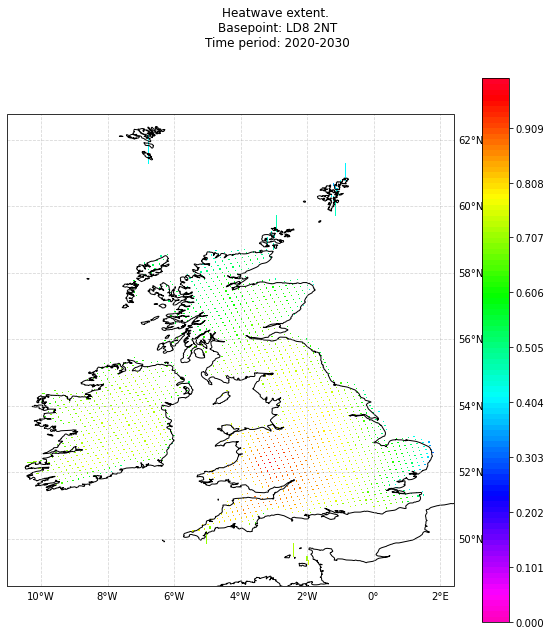

2 500


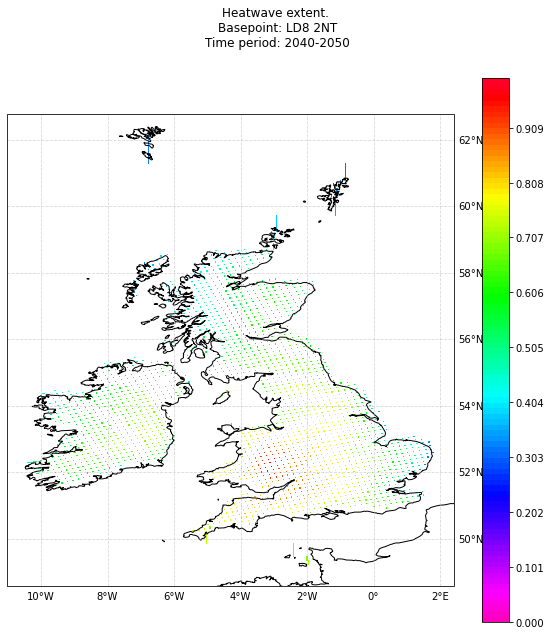

In [20]:
# plot initial view
t=0
p=500
s = pd.Series(data=data[t][p], index=idx)
da = xr.DataArray.from_series(s)
display(tdrop)
display(pdrop)
plot(da)
